In [1]:
import spacedecomp
from spacedecomp.kernels import RBF, Matern, Periodic
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
kernels = [RBF, Matern, Periodic]

## Sample from sine function with noise

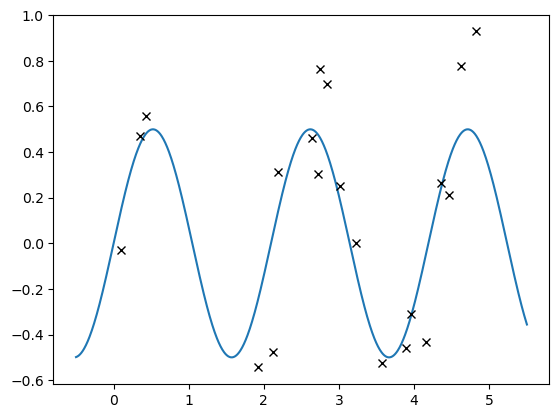

In [3]:
np.random.seed(0)
N = 20
X = 5*np.random.rand(N)
y = 0.5 *np.sin(3 * X) + 0.2*np.random.randn(N)

Nsamples = 1000
Xtest = np.linspace(-0.5, 5.5, Nsamples)




plt.plot(Xtest, 0.5*np.sin(3*Xtest))
plt.plot(X, y, "kx")

### Test samples of using different variance and lenghtscales

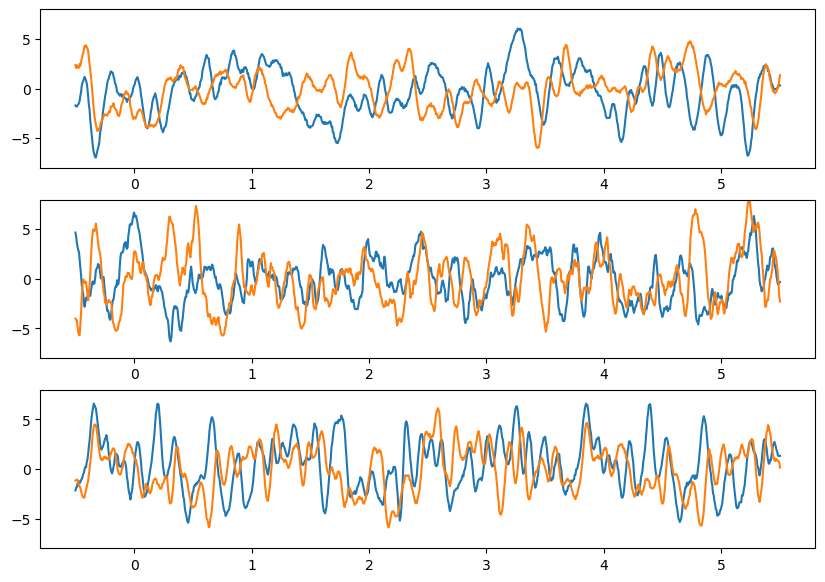

In [4]:
plt.figure(figsize=(10, 7))

for i, kernel_class in enumerate(kernels):

    kernel = kernel_class(
    variance=6.0, lengthscale= 0.05 )

    
    gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
    cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
    samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((2,))
    
    plt.subplot(len(kernels), 1, i+1)
    plt.plot(Xtest, samples[0])
    plt.plot(Xtest, samples[1])
    plt.ylim((-8, 8))

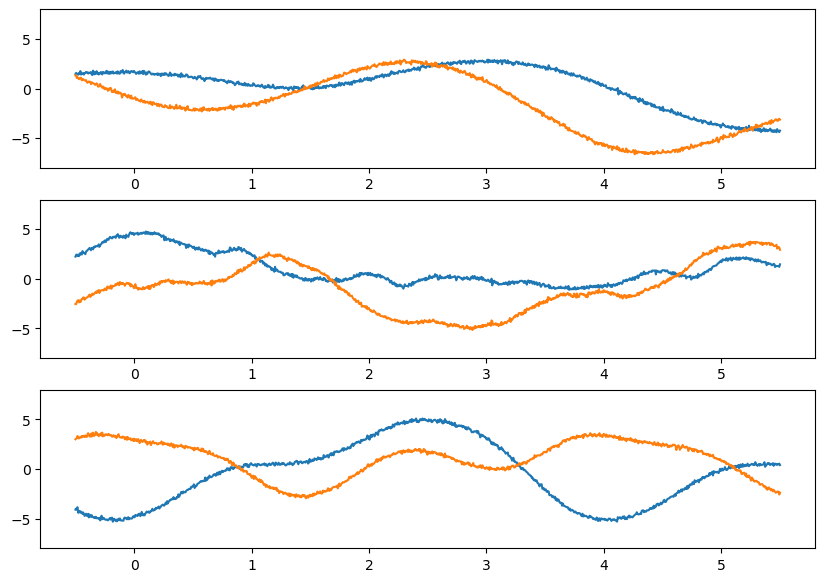

In [5]:
plt.figure(figsize=(10, 7))

for i, kernel_class in enumerate(kernels):

    kernel = kernel_class(
    variance=6.0, lengthscale= 1 )

    
    gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
    cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
    samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((2,))
    
    plt.subplot(len(kernels), 1, i+1)
    plt.plot(Xtest, samples[0])
    plt.plot(Xtest, samples[1])
    plt.ylim((-8, 8))

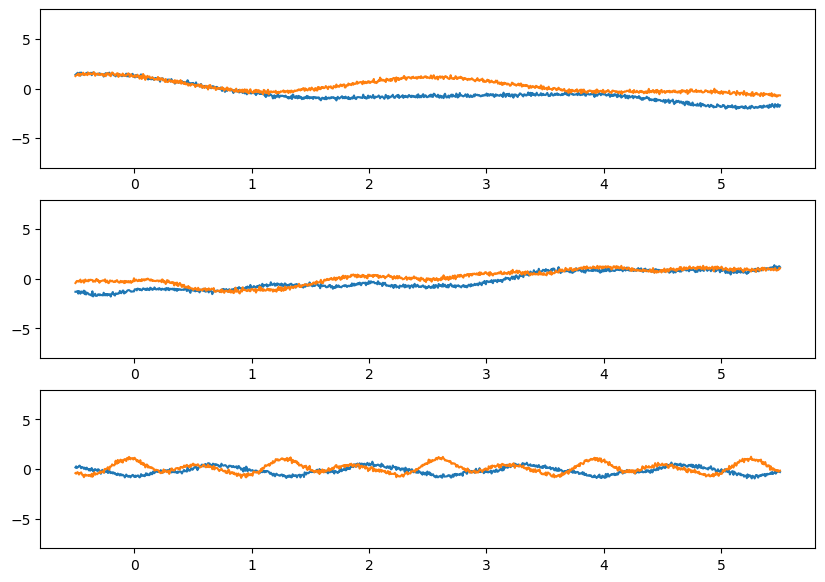

In [6]:
plt.figure(figsize=(10, 7))

for i, kernel_class in enumerate(kernels):

    kernel = kernel_class(
    variance=1, lengthscale= 1 )

    
    gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
    cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
    samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((2,))
    
    plt.subplot(len(kernels), 1, i+1)
    plt.plot(Xtest, samples[0])
    plt.plot(Xtest, samples[1])
    plt.ylim((-8, 8))

## Train GP

Finished Training


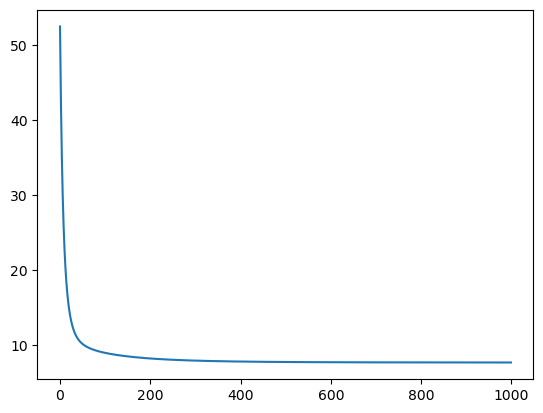

In [7]:
kernel = RBF()
gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
history = gpr.fit(optimizer=optim.Adam, epochs=1000)
plt.plot(history)

## Get posterior distribution

In [8]:
Nsamples = 200
Xtest = np.linspace(-0.5, 5.5, Nsamples)
with torch.no_grad():
    mean, cov = gpr.predict(Xtest[:,None])
    sd = cov.diag().sqrt()
    mean = mean

mean:  torch.Size([200])
covariance:  torch.Size([200, 200])


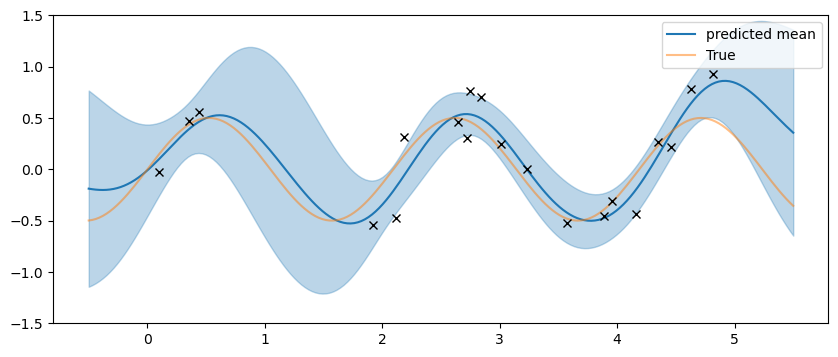

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(Xtest, mean, label='predicted mean')
plt.plot(Xtest, 0.5*np.sin(3*Xtest), alpha=0.5, label='True')
plt.fill_between(
            Xtest,
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(X, y, "kx")
plt.ylim((-1.5, 1.5))
plt.legend()

### Visualize sampled functions

In [10]:
with torch.no_grad():
    posterior_cov = cov + (5e-3**2)*torch.eye(Nsamples) #add small noise for it to be PD
    L = torch.linalg.cholesky(posterior_cov)
    posterior_dist = MultivariateNormal(mean, scale_tril=L)

(-1.5, 1.5)

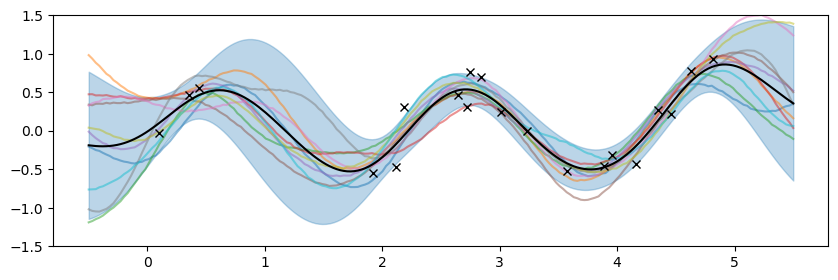

In [11]:
N_functions = 10
samples = posterior_dist.sample((N_functions,))

plt.figure(figsize=(10, 3))
plt.fill_between(
            Xtest,
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        
for i in range(N_functions):
    plt.plot(Xtest, samples[i], alpha=0.5)


plt.plot(X, y, "kx")
plt.plot(Xtest, mean, color='black')
plt.ylim((-1.5, 1.5))